In [1]:
import numpy as np
from mpmath import mp, mpf, sin, cos, pi, fadd, fsub, fmul, fdiv
import matplotlib.pyplot as plt

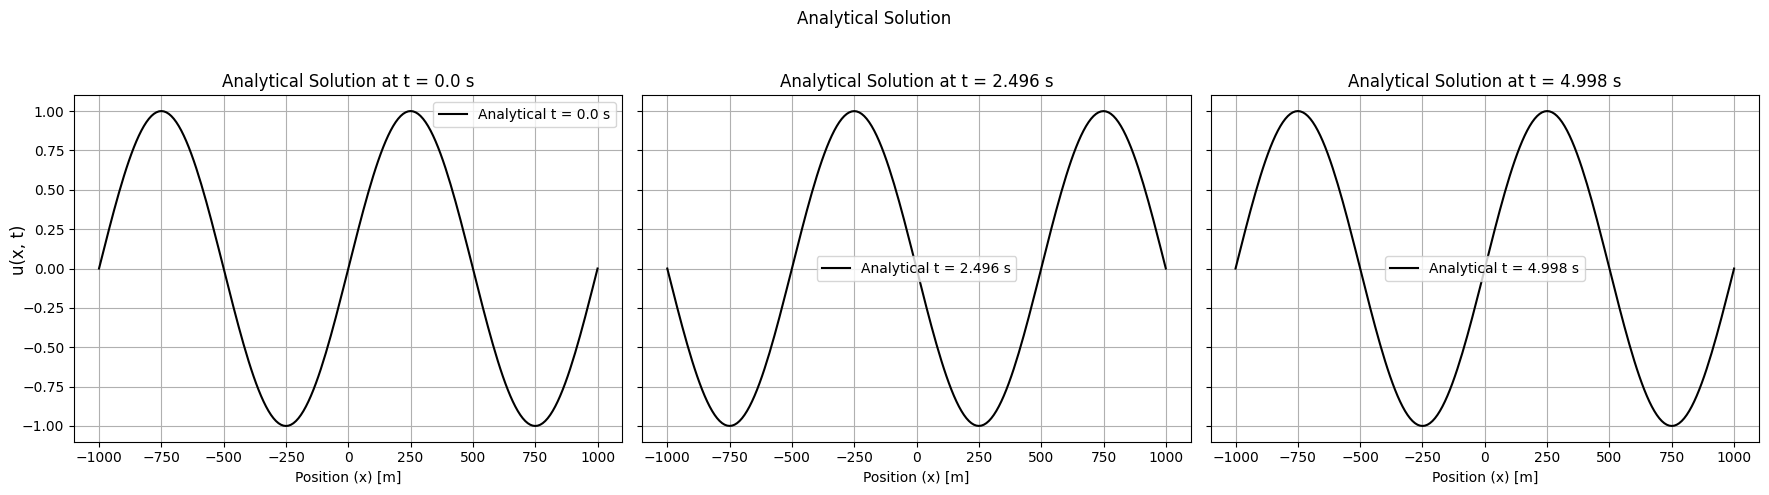

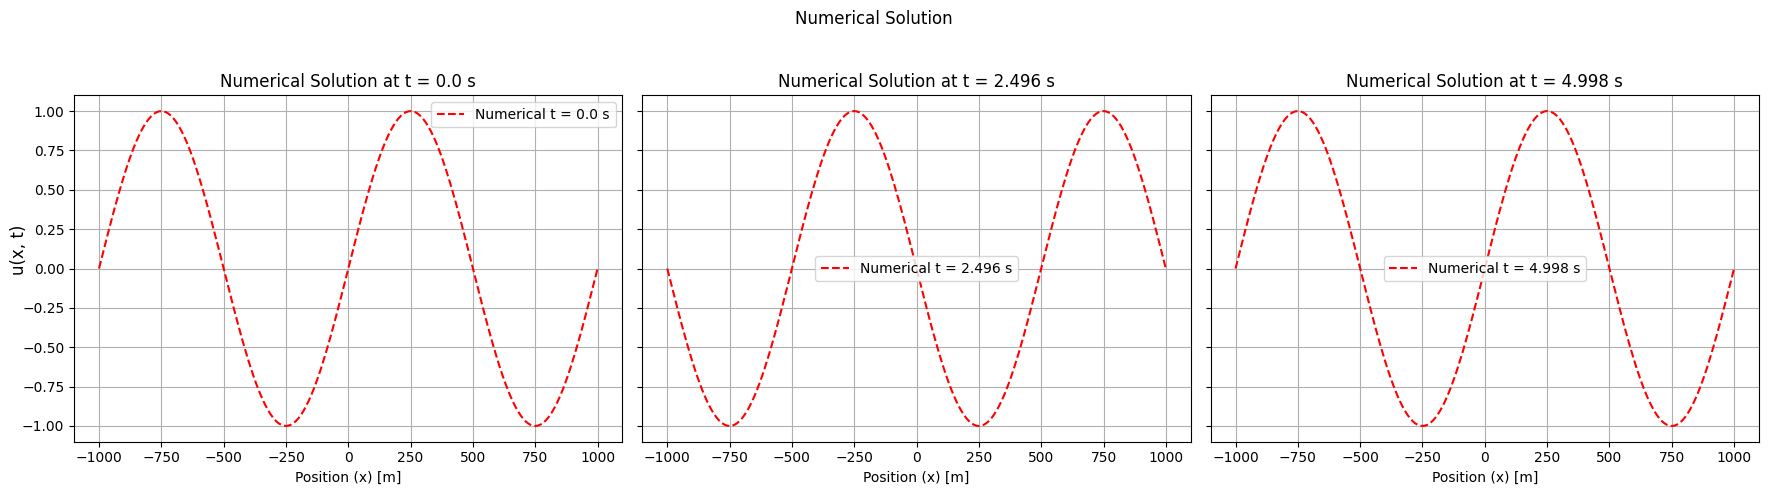

In [31]:
# Set precision
mp.prec = 23

# Constants
L = mpf(1000)                 # Half-length of the domain in meters
c = mpf(1000)                 # Wave speed in m/s
N = 201                       # Number of spatial points
dx = 2 * L / (N - 1)          # Spatial step size for [-L, L] domain
dt = mpf(0.6 * dx / c)        # Time step size (CFL condition)
T = mpf(5.0)                  # Total simulation time in seconds
x = [mpf(val) for val in np.linspace(float(-L), float(L), N)]  # Spatial grid as mpf

# Total time steps
Nt = int(T / dt) + 1

# Initialize the wave field
u = [sin(2 * pi * x_i / L) for x_i in x]  # Initial condition u(x, 0)
u_prev = u.copy()                         # Initial velocity is zero: u_t(x, 0) = 0
u_next = [mpf(0)] * N                     # Placeholder for the next time step

# Dynamic time indices for plotting
plot_times = [0, Nt // 2 -1, Nt-1]  # Start, middle, and end of the time range
u_num_at_t = {}

# Main time evolution loop
for n in range(Nt):
    # Store the results for specific time indices
    if n in plot_times:
        u_num_at_t[n] = u.copy()  # Store the wave profile at the specified time indices
    
    # Compute the next time step using finite difference
    for i in range(1, N - 1):
        # Compute coefficients explicitly
        coeff = fdiv(fmul(mpf(c), mpf(dt)), mpf(dx))
        coeff_squared = fmul(coeff, coeff)  # (c * dt / dx) ** 2
        
        # Update u_next[i] using explicit mpmath operations
        term1 = fmul(mpf(2), u[i])  # 2 * u[i]
        term2 = fsub(u[i + 1], fmul(mpf(2), u[i]))  # u[i + 1] - 2 * u[i]
        term2 = fadd(term2, u[i - 1])  # u[i + 1] - 2 * u[i] + u[i - 1]
        update = fmul(coeff_squared, term2)  # (c * dt / dx) ** 2 * (term2)
        u_next[i] = fadd(fsub(term1, u_prev[i]), update)  # 2 * u[i] - u_prev[i] + update
    
    # Apply boundary conditions
    u_next[0] = mpf(0)  # Fixed boundary
    u_next[-1] = mpf(0)

    # Update arrays for the next time step
    u_prev = u.copy()
    u = u_next.copy()


# Analytical Solution
def analytical_solution(x, t, c, L):
    return [cos(2 * pi * c * t / L) * sin(2 * pi * x_i / L) for x_i in x]

## Plotting the analytical solution
fig1, axs1 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = round(idx * dt, 3)
    # Analytical solution at time t
    u_analytic = analytical_solution(x, t, c, L)
    axs1[i].plot([float(x_i) for x_i in x], [float(u_a) for u_a in u_analytic], 'k-', label=f"Analytical t = {float(t)} s")

    # Plot formatting
    axs1[i].set_xlabel("Position (x) [m]")
    axs1[i].set_title(f"Analytical Solution at t = {float(t)} s")
    axs1[i].legend()
    axs1[i].grid(True)

# Set global y-axis label
fig1.supylabel("u(x, t)")
fig1.suptitle("Analytical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

# Plotting the numerical solution
fig2, axs2 = plt.subplots(1, 3, figsize=(18, 5), sharey=True)
for i, idx in enumerate(plot_times):
    t = round(idx * dt, 3)
    # Retrieve the numerical solution for the mapped time index
    u_num = u_num_at_t[idx]
    axs2[i].plot([float(x_i) for x_i in x], [float(u_n) for u_n in u_num], 'r--', label=f"Numerical t = {float(t)} s")

    # Plot formatting
    axs2[i].set_xlabel("Position (x) [m]")
    axs2[i].set_title(f"Numerical Solution at t = {float(t)} s")
    axs2[i].legend()
    axs2[i].grid(True)

# Set global y-axis label
fig2.supylabel("u(x, t)")
fig2.suptitle("Numerical Solution")
plt.tight_layout(rect=[0, 0, 1, 0.95])

plt.show()


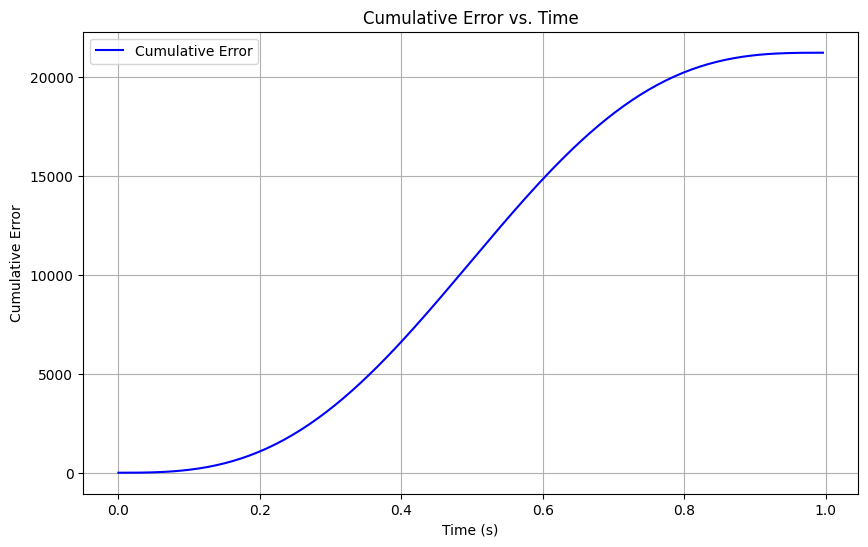

Average error per time step: 126.99076080322266


In [24]:
from mpmath import fabs, fadd, fsum

# Initialize variables to store cumulative error and the list of errors at each time step
cumulative_error = mpf(0.0)
cumulative_errors = []
errors = []

# Loop through each time step to calculate numerical and analytical solutions and accumulate the error
for n in range(Nt):
    t = fmul(n, dt)  # Current time step as an mpf
    
    # Retrieve the numerical solution for the current time step
    numerical_solution = u.copy()
    
    # Calculate the analytical solution at this time step
    analytical_solution_values = analytical_solution(x, t, c, L)
    
    # Calculate the error (absolute difference between numerical and analytical solutions)
    error = [fabs(fsub(numerical_solution[i], analytical_solution_values[i])) for i in range(N)]
    
    # Sum the error for this time step to the cumulative error
    cumulative_error = fadd(cumulative_error, fsum(error))
    errors.append(error)
    cumulative_errors.append(float(cumulative_error))  # Convert to float for plotting

# Example plot: Cumulative Error vs. Time
time_values = [float(fmul(n, dt)) for n in range(Nt)]  # Time array from 0 to T in steps of dt

# Plot cumulative error over time
plt.figure(figsize=(10, 6))
plt.plot(time_values, cumulative_errors, label="Cumulative Error", color="blue")
plt.xlabel("Time (s)")
plt.ylabel("Cumulative Error")
plt.title("Cumulative Error vs. Time")
plt.legend()
plt.grid()
plt.show()

# Calculate and print average error per time step
average_error_per_timestep = cumulative_error / Nt
print('Average error per time step:', float(average_error_per_timestep))
